# Plan de Trabajo para el proyecto de Predicción de Cancelación de Clientes en Interconnect

**Objetivo:**

Desarrollar un modelo que pueda predecir la tasa de cancelación de clientes para que el equipo de marketing pueda ofrecer incentivos a aquellos en riesgo de abandonar el servicio.

**Servicios de Interconnect**

**Interconnect proporciona principalmente dos tipos de servicios:**

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

**Algunos otros servicios que ofrece la empresa incluyen:**

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

**Preguntas a Responder:**

1. ¿Cuáles son los factores más influyentes en la decisión de un cliente de cancelar su contrato?

Descripción: Identificar las variables (como tipo de servicio, duración del contrato, método de pago, etc.) que tienen mayor correlación con la cancelación del servicio.
Fuente de Datos: contract.csv, personal.csv, internet.csv, phone.csv.

2. ¿Cómo se distribuye la tasa de cancelación entre los diferentes tipos de contratos y métodos de pago?

Descripción: Examinar si hay patrones claros de cancelación relacionados con la duración del contrato o el método de pago elegido.
Fuente de Datos: contract.csv.

3. ¿Cómo se distribuye la tasa de cancelación entre los diferentes tipos de internet?

Descripción: Analizar la relación entre el tipo de servicio contratado y la propensión a cancelar el servicio.
Fuente de Datos: internet.csv

4. ¿Qué características demográficas de los clientes están asociadas con una mayor tasa de cancelación?

Descripción: Evaluar si ciertos grupos demográficos, como edad o género, están más inclinados a cancelar sus contratos.
Fuente de Datos: personal.csv.


**Siguientes Pasos:**

1. Revisión y Limpieza de Datos: Inspeccionar los archivos para asegurar la calidad de los datos y realizar un tratamiento preliminar (manejo de valores faltantes, normalización, etc.).

2. Análisis Exploratorio de Datos (EDA): Realizar un EDA para entender mejor la distribución de las variables y las relaciones entre ellas.

3. Ingeniería de Características: modificación o creación de nuevas variables que puedan mejorar el rendimiento del modelo, como interacciones entre servicios, duración del contrato en meses, etc.

4. Modelado Predictivo: Entrenar varios modelos de machine learning para predecir la cancelación de clientes, tomando como métrica principal el valor AUC-ROC

5. Evaluación e Interpretación: Evaluar el modelo final y generar un informe con las recomendaciones basadas en los hallazgos, listo para su implementación por el equipo de marketing.

**Descripción de los datos**

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Inicialización

In [1]:
#Importar librerias
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as ltb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

In [2]:
#Cargar datos
contract = pd.read_csv('contract.csv', parse_dates = [1])
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')

## Procesamiento de los datos

**Visualización de los datos e información general**


In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


No existen valores nulos o vacíos en las columnas pero podríamos cambiar el tipo de dato a la columna TotalCharges para un mejor tratamiento posterior

In [5]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Tampoco existen datos nulos en este dataframe, pero podríamos cambiar el tipo de dato a la mayoría de las columnas para poder usarlas de mejor manera en la creación del modelo.

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


No existen valores nulos, nuevamente se podría cambiar el tipo de dato a las columnas para su mejor procesamiento

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


No existen valores nulos, podríamos cambiar el tipo a boleano de la columna MultipleLines

**Procedemos a unir todas las tablas**

In [11]:
# Unimos los dataframes en 'customerID'
merged_df = (
    contract.merge(internet, on='customerID', how='left')
    .merge(personal, on='customerID', how='left')
    .merge(phone, on='customerID', how='left')
)

# Mostramos las primeras columnas del dataframe
merged_df.head()


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [13]:
# Número de duplicados 
merged_df.duplicated().sum()

0

### Procesamiento de columnas categóricas

In [14]:
#Creación de lista con las columnas categóricas booleanas
cat_columns = [
    'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport'
    , 'StreamingTV', 'StreamingMovies', 'Partner','Dependents', 'MultipleLines']

In [15]:
#asignar 1 a 'Yes' y No a 0 y none en estas columnas
for col in cat_columns:
  merged_df.loc[merged_df[col] == 'Yes', col] = 1
  merged_df.loc[merged_df[col] != 1, col] = 0

  merged_df[col] = merged_df[col].astype('int')

In [16]:
#Información del dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    7043 non-null   int64         
 10  OnlineBackup      7043 non-null   int64         
 11  DeviceProtection  7043 non-null   int64         
 12  TechSupport       7043 non-null   int64         
 13  StreamingTV       7043 non-null   int64         
 14  StreamingMovies   7043 n

Podemos ver que los valores ausentes se rellenaron

In [17]:
#Exploración de las demás columnas categóricas
for col in ['Type', 'PaymentMethod', 'InternetService','gender']:
    print(col)  
    print(merged_df[col].unique())

Type
['Month-to-month' 'One year' 'Two year']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
InternetService
['DSL' 'Fiber optic' nan]
gender
['Female' 'Male']


In [18]:
#Llenar valores ausentes de la columna InternetService 
merged_df['InternetService'] = merged_df['InternetService'].fillna('Unknown')

In [19]:
#Vistazo del dataframe sin valores ausentes
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   int64         
 10  OnlineBackup      7043 non-null   int64         
 11  DeviceProtection  7043 non-null   int64         
 12  TechSupport       7043 non-null   int64         
 13  StreamingTV       7043 non-null   int64         
 14  StreamingMovies   7043 n

In [20]:
#Ordenar fechas
merged_df = merged_df.sort_values('BeginDate')
merged_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
4513,8580-QVLOC,2013-10-01,2019-10-01 00:00:00,Two year,0,Credit card (automatic),92.45,6440.25,DSL,1,1,1,1,1,1,Female,1,1,1,1
4610,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,1,Bank transfer (automatic),117.80,8684.8,Fiber optic,1,1,1,1,1,1,Male,0,1,0,1
3439,0917-EZOLA,2013-10-01,2019-10-01 00:00:00,Two year,1,Bank transfer (automatic),104.15,7689.95,Fiber optic,0,1,1,0,1,1,Male,1,1,0,1
975,2834-JRTUA,2013-11-01,2019-10-01 00:00:00,Two year,1,Electronic check,108.05,7532.15,Fiber optic,1,0,1,1,1,1,Male,0,0,0,1
3040,7317-GGVPB,2013-11-01,2019-10-01 00:00:00,Two year,1,Credit card (automatic),108.60,7690.9,Fiber optic,0,1,1,1,1,1,Male,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,,Unknown,0,0,0,0,0,0,Male,0,1,1,0
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,,DSL,0,1,1,1,1,0,Female,0,1,1,1
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,,DSL,1,1,1,0,1,1,Female,0,1,1,0
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,,Unknown,0,0,0,0,0,0,Male,0,1,1,1


### Procesamiento de columnas numéricas

In [21]:
#Exploración de la columna TotalCharges
merged_df['TotalCharges'].value_counts().sort_values()

134.35      1
1205.5      1
1654.45     1
5067.45     1
3229.4      1
           ..
19.65       8
20.05       8
19.75       9
20.2       11
           11
Name: TotalCharges, Length: 6531, dtype: int64

In [22]:
#Exploración de valores ausentes en TotalCharges
merged_df[merged_df['TotalCharges'] == ' ']     

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
753,3115-CZMZD,2020-02-01,No,Two year,0,Mailed check,20.25,,Unknown,0,0,0,0,0,0,Male,0,0,1,0
5218,2923-ARZLG,2020-02-01,No,One year,1,Mailed check,19.70,,Unknown,0,0,0,0,0,0,Male,0,1,1,0
4380,2520-SGTTA,2020-02-01,No,Two year,0,Mailed check,20.00,,Unknown,0,0,0,0,0,0,Female,0,1,1,0
488,4472-LVYGI,2020-02-01,No,Two year,1,Bank transfer (automatic),52.55,,DSL,1,0,1,1,1,0,Female,0,1,1,0
1082,4367-NUYAO,2020-02-01,No,Two year,0,Mailed check,25.75,,Unknown,0,0,0,0,0,0,Male,0,1,1,1
1340,1371-DWPAZ,2020-02-01,No,Two year,0,Credit card (automatic),56.05,,DSL,1,1,1,1,1,0,Female,0,1,1,0
3331,7644-OMVMY,2020-02-01,No,Two year,0,Mailed check,19.85,,Unknown,0,0,0,0,0,0,Male,0,1,1,0
6670,4075-WKNIU,2020-02-01,No,Two year,0,Mailed check,73.35,,DSL,0,1,1,1,1,0,Female,0,1,1,1
936,5709-LVOEQ,2020-02-01,No,Two year,0,Mailed check,80.85,,DSL,1,1,1,0,1,1,Female,0,1,1,0
3826,3213-VVOLG,2020-02-01,No,Two year,0,Mailed check,25.35,,Unknown,0,0,0,0,0,0,Male,0,1,1,1


Se puede apreciar que la columna TotalCharges se tienen valores ausentes para los usuarios que acaban de adquirir el servicio pero aún no han llegado a su primera facturación, al ser sólo 11 se procede a eliminar estas filas para facilitar futuros análisis, además se cambia el tipo de la columna a float

In [23]:
merged_df = merged_df[merged_df['TotalCharges'] != ' ']

In [24]:
#Cambiar de tipo a la columna totalcharges a float y verificamos cambios
merged_df['TotalCharges'] = merged_df['TotalCharges'].astype('float')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 4513 to 211
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   int64         
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7032 non-null   object        
 9   OnlineSecurity    7032 non-null   int64         
 10  OnlineBackup      7032 non-null   int64         
 11  DeviceProtection  7032 non-null   int64         
 12  TechSupport       7032 non-null   int64         
 13  StreamingTV       7032 non-null   int64         
 14  StreamingMovies   7032

/tmp/ipykernel_82/2116179903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['TotalCharges'] = merged_df['TotalCharges'].astype('float')


In [25]:
#Exploración de la columna TotalCharges
merged_df['MonthlyCharges'].value_counts().sort_values()

97.25      1
113.30     1
58.45      1
42.90      1
111.40     1
          ..
19.65     43
19.95     44
19.90     44
19.85     44
20.05     61
Name: MonthlyCharges, Length: 1584, dtype: int64

In [26]:
#Exploración de valores ausentes en MonthlyCharges
merged_df[merged_df['MonthlyCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


In [27]:
#Creación de la columna objetivo
merged_df['Target'] = (merged_df['EndDate'] != "No").astype("int")
merged_df.head()

/tmp/ipykernel_82/2887286259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Target'] = (merged_df['EndDate'] != "No").astype("int")


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Target
4513,8580-QVLOC,2013-10-01,2019-10-01 00:00:00,Two year,0,Credit card (automatic),92.45,6440.25,DSL,1,...,1,1,1,1,Female,1,1,1,1,1
4610,2889-FPWRM,2013-10-01,2019-10-01 00:00:00,One year,1,Bank transfer (automatic),117.80,8684.80,Fiber optic,1,...,1,1,1,1,Male,0,1,0,1,1
3439,0917-EZOLA,2013-10-01,2019-10-01 00:00:00,Two year,1,Bank transfer (automatic),104.15,7689.95,Fiber optic,0,...,1,0,1,1,Male,1,1,0,1,1
975,2834-JRTUA,2013-11-01,2019-10-01 00:00:00,Two year,1,Electronic check,108.05,7532.15,Fiber optic,1,...,1,1,1,1,Male,0,0,0,1,1
3040,7317-GGVPB,2013-11-01,2019-10-01 00:00:00,Two year,1,Credit card (automatic),108.60,7690.90,Fiber optic,0,...,1,1,1,1,Male,0,1,0,1,1


## Análisis exploratorio de datos

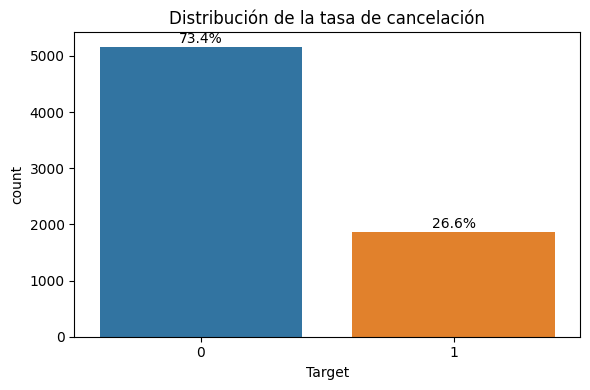

In [29]:
# Distribución de la tasa de cancelación de clientes 
plt.figure(figsize=(6,4))
ax = sns.countplot(x='Target', data=merged_df)
plt.title('Distribución de la tasa de cancelación')
total = len(merged_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se puede observar en el gráfico anterior que la cantidad de clientes que cancelaron el servicio representan el 26.6%, un poco menos de un tercio del total.  

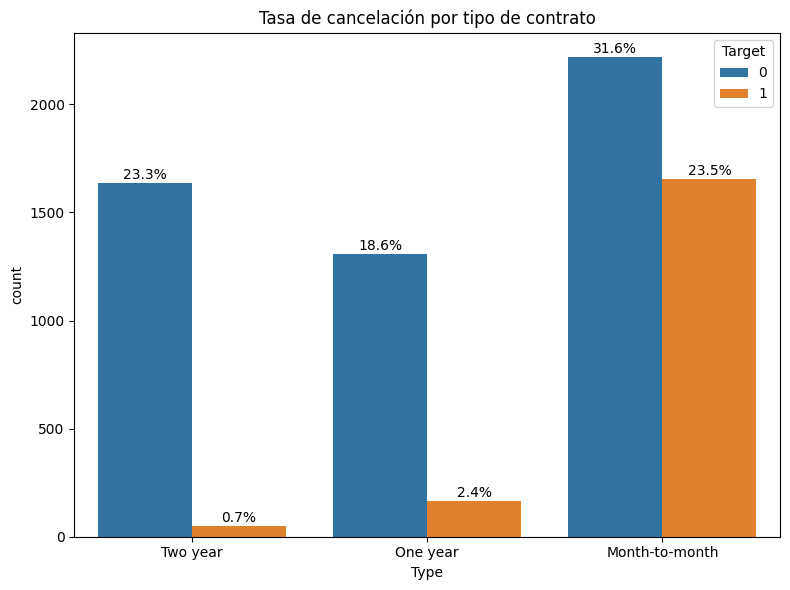

In [30]:
# Tasa de cancelación de clientes en diferentes tipos de contratos
plt.figure(figsize=(8,6))
ax1 = sns.countplot(x='Type', hue='Target', data=merged_df)
plt.title('Tasa de cancelación por tipo de contrato')
total = len(merged_df)
for p in ax1.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Podemos ver que la tasa de cancelación se concentra en su mayoría en los clientes que tienen un contracto de mes a mes.

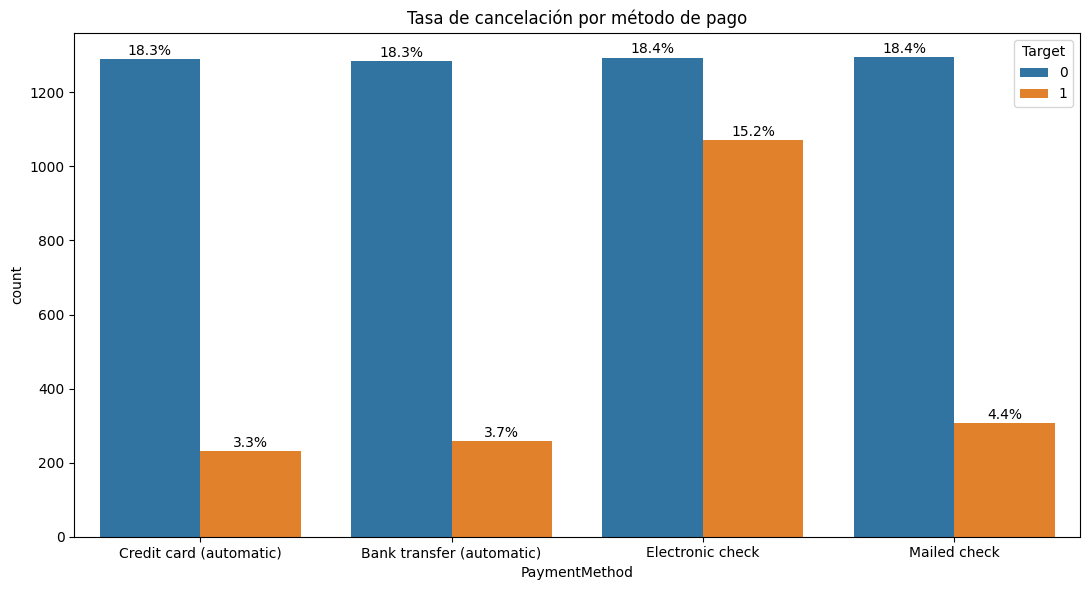

In [31]:
# Tasa de abandono de clientes dependiento el método de pago 
plt.figure(figsize=(11,6))
ax3=sns.countplot(x='PaymentMethod', hue='Target', data=merged_df)
plt.title('Tasa de cancelación por método de pago')
total = len(merged_df)
for p in ax3.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax3.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

En cuánto a los métodos de pago, los clientes que usan el cheque electrónico son los que más cancelan su servicio, por otro lado las menores tasas se dan cuando el pago se realiza de manera automática ya sea por transferencia bancaria o tarjeta de crédito.

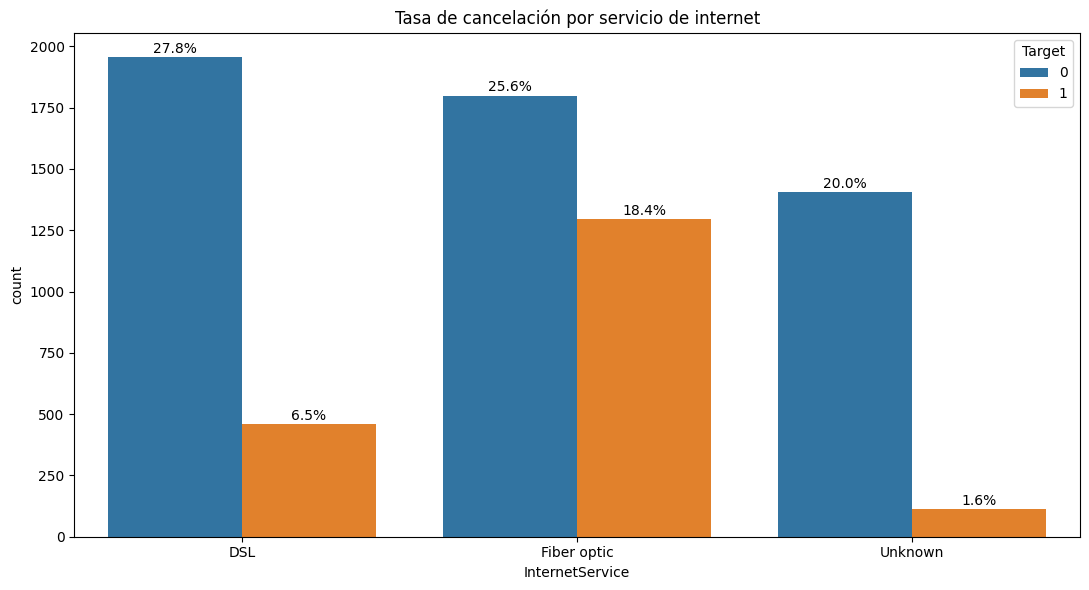

In [32]:
#Tasa de cancelación de clientes que utilizan servicios de internet
plt.figure(figsize=(11,6))
ax4=sns.countplot(x='InternetService', hue='Target', data=merged_df)
plt.title('Tasa de cancelación por servicio de internet')
total = len(merged_df)
for p in ax4.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax4.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

La mayor tasa de cancelación dependiendo del servicio de internet que se utiliza, se da con los clientes del servicio de fibra óptica

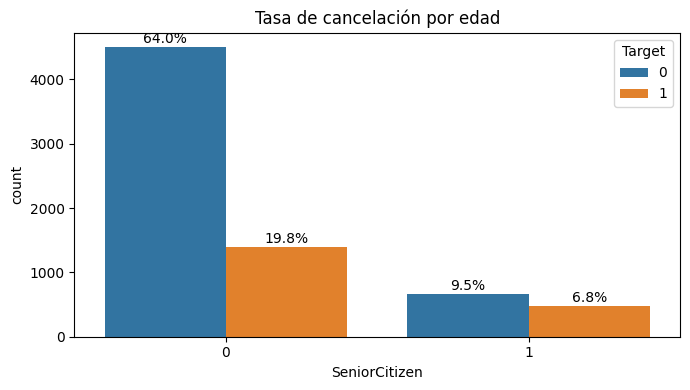

In [33]:
#Tasa de cancelación por edad
plt.figure(figsize=(7,4))
ax5=sns.countplot(x='SeniorCitizen', hue='Target', data=merged_df)
plt.title('Tasa de cancelación por edad')
total = len(merged_df)
for p in ax5.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax5.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()


En los clientes que no son considerados ciudadanos mayores la tasa de cancelación es mayor, sin embargo tenemos que considerar que la mayoría cae dentro de este grupo, representando solo el 19% del total, mientras que la tasa de cancelación para los clientes considerados mayores es casi igual que los que aún cuentan con el servicio dentro de este grupo.

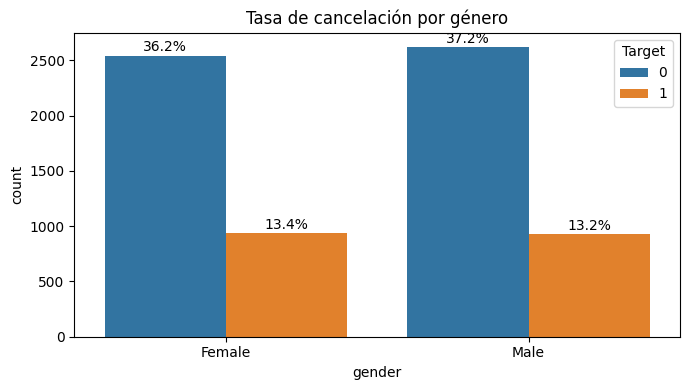

In [34]:
plt.figure(figsize=(7,4))
ax6=sns.countplot(x='gender', hue='Target', data=merged_df)
plt.title('Tasa de cancelación por género')
total = len(merged_df)
for p in ax6.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax6.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

La candidade personas de género masculino y femenino es casi el mismo, al igual que su incidencia en la tasa de cancelación del servicio ambos en 13% aproximadamente, esto nos hace saber de antemano que es una variable que no sería influyente en la construcción de un futuro modelo de predicción ya que no tiene impacto sobre el objetivo.

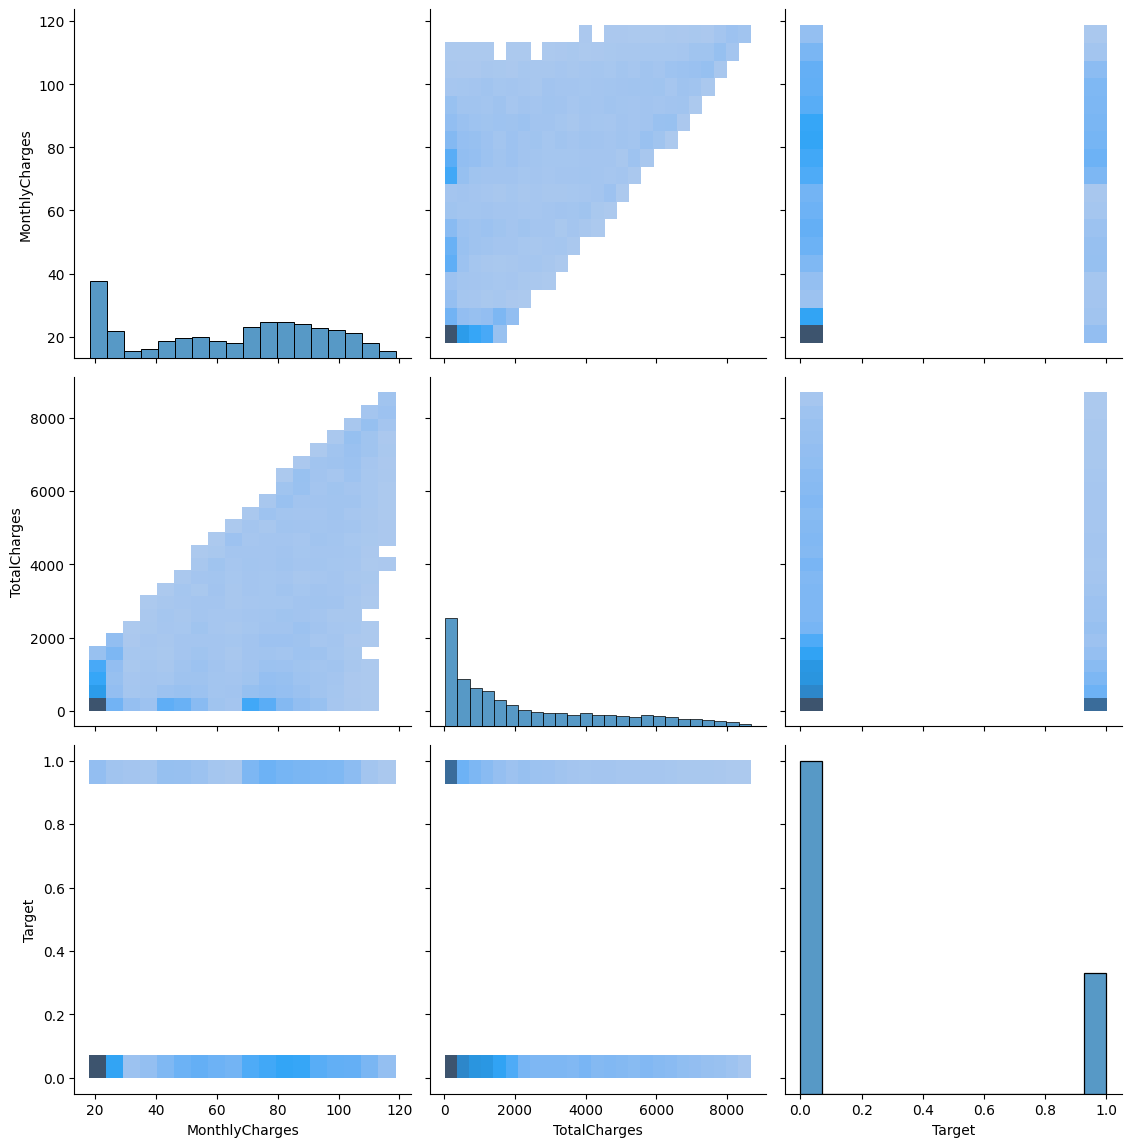

In [35]:
# Correlación de variables numéricas 
num_var = sns.pairplot(merged_df[['MonthlyCharges', 'TotalCharges', 'Target']], kind='hist')
num_var.fig.set_size_inches(12, 12)

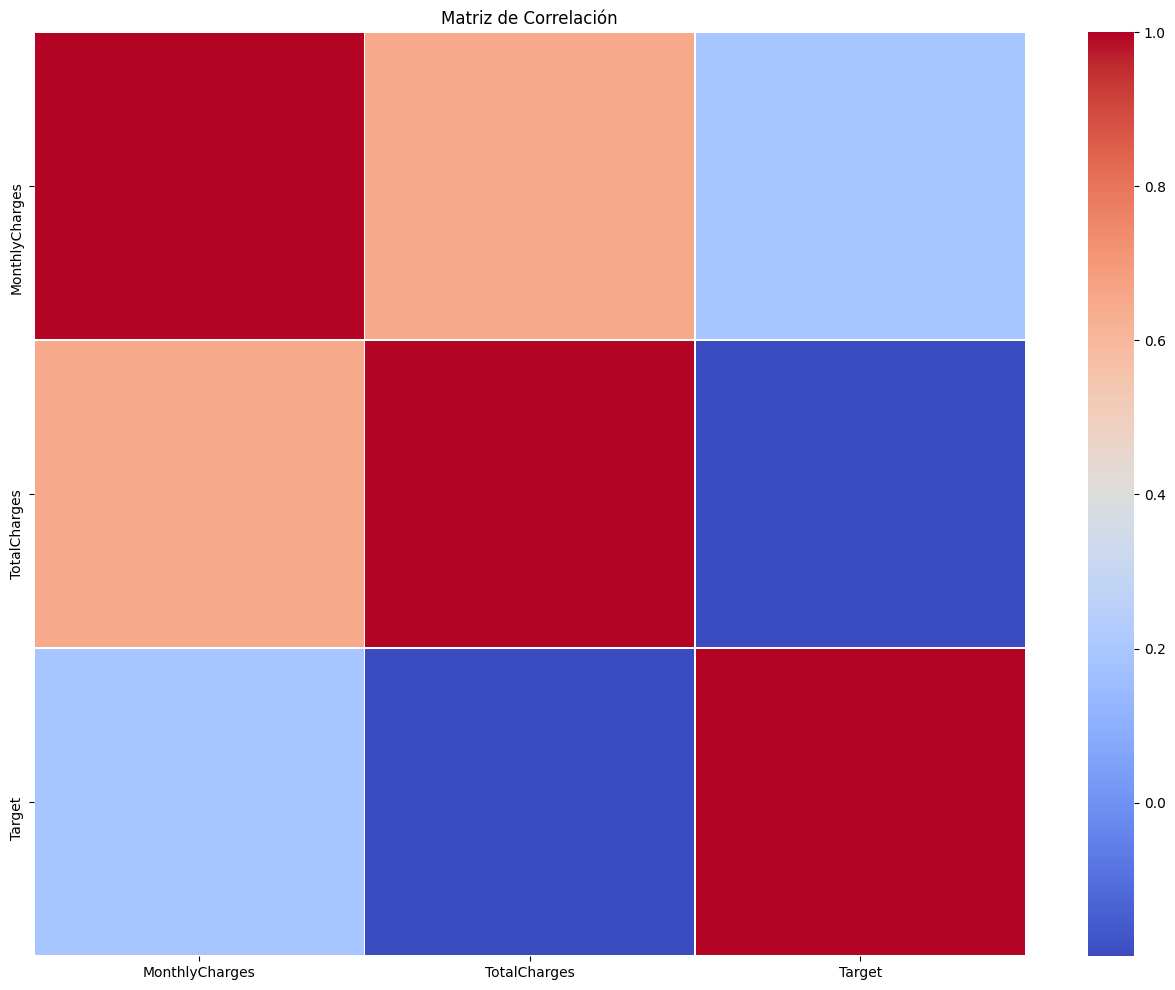

In [56]:
# Convertir variables categóricas a numéricas para ver su correlación
df_numerical = merged_df[['MonthlyCharges', 'TotalCharges', 'Target']]

# Matriz de correlación 
corr = df_numerical.corr()

# Mapa de calor 
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Existe una correlación mas alta de la variable cargos mensuales en comparación con los cargos totales con respecto a la variable objetivo.

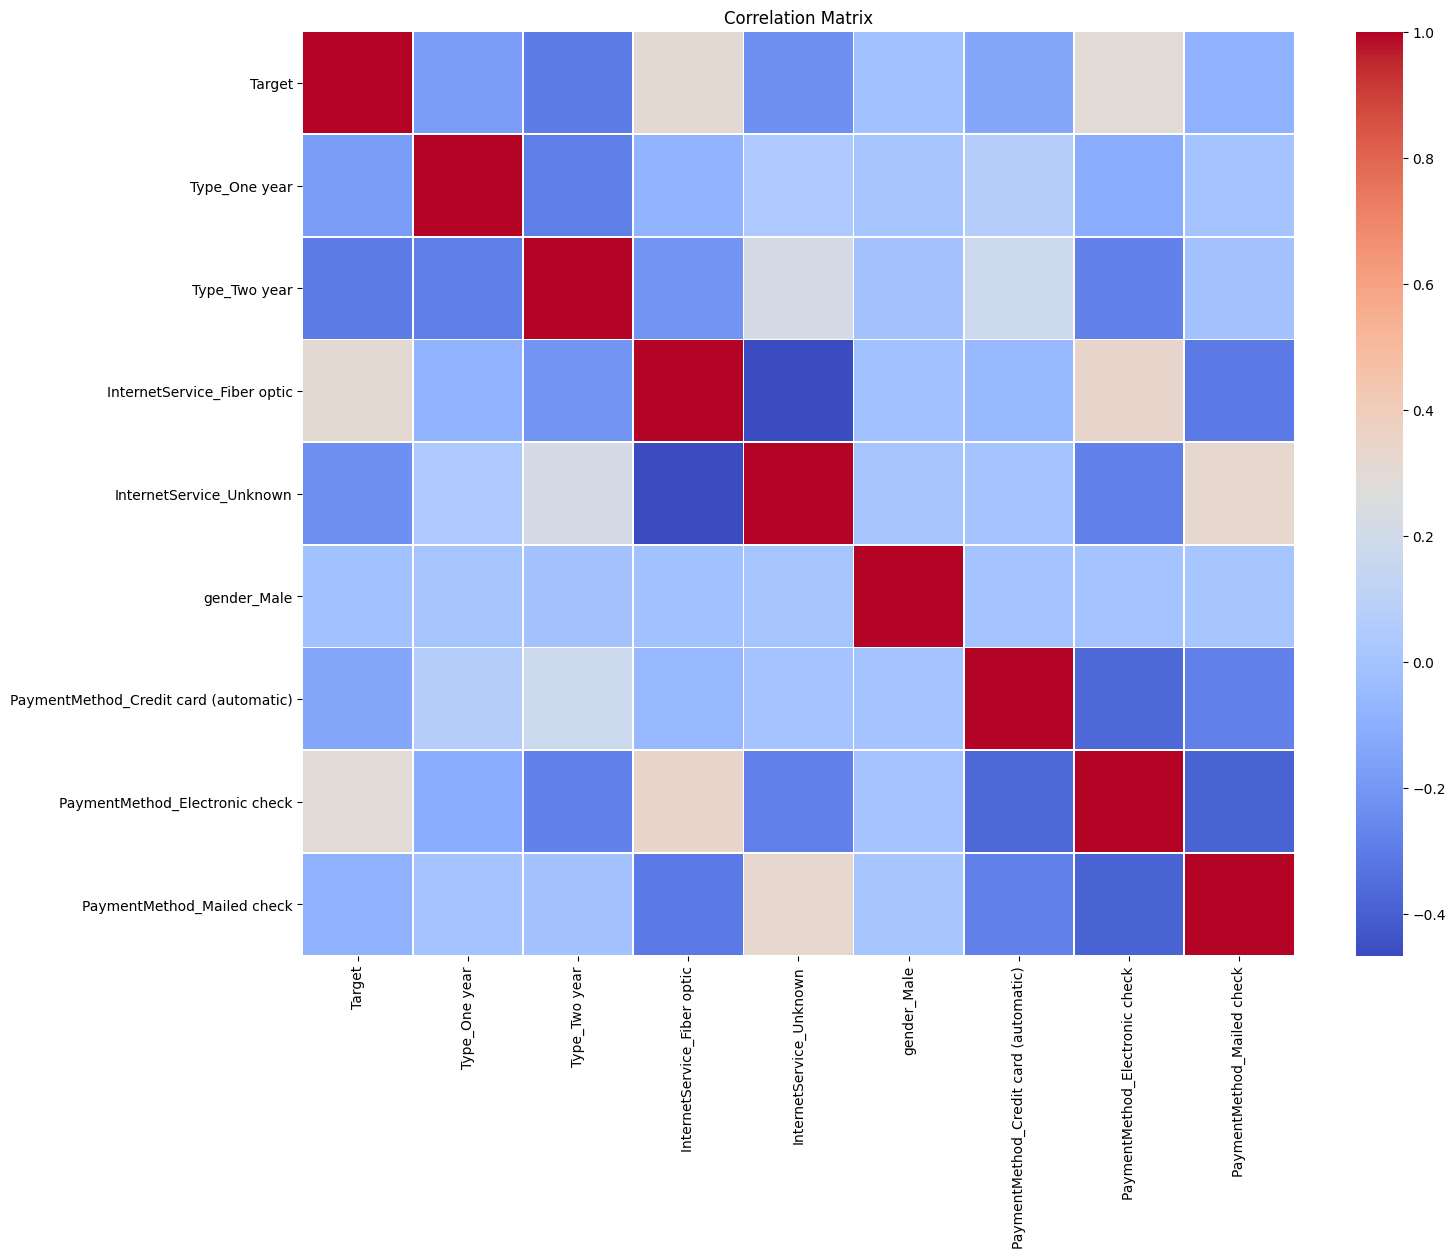

In [38]:
# Convertir variables categóricas para ver su correlación
df_categorical = pd.get_dummies(merged_df[['Type', 'InternetService', 'gender', 'PaymentMethod','Target']], drop_first=True)

# Matriz de correlación 
corr = df_categorical.corr()

# Mapa de calor 
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

El servicio de internet de fibra óptica y el método de pago a travéz de cheque electrónico son las variables que tienen una correlación más alta con la variable objetivo.

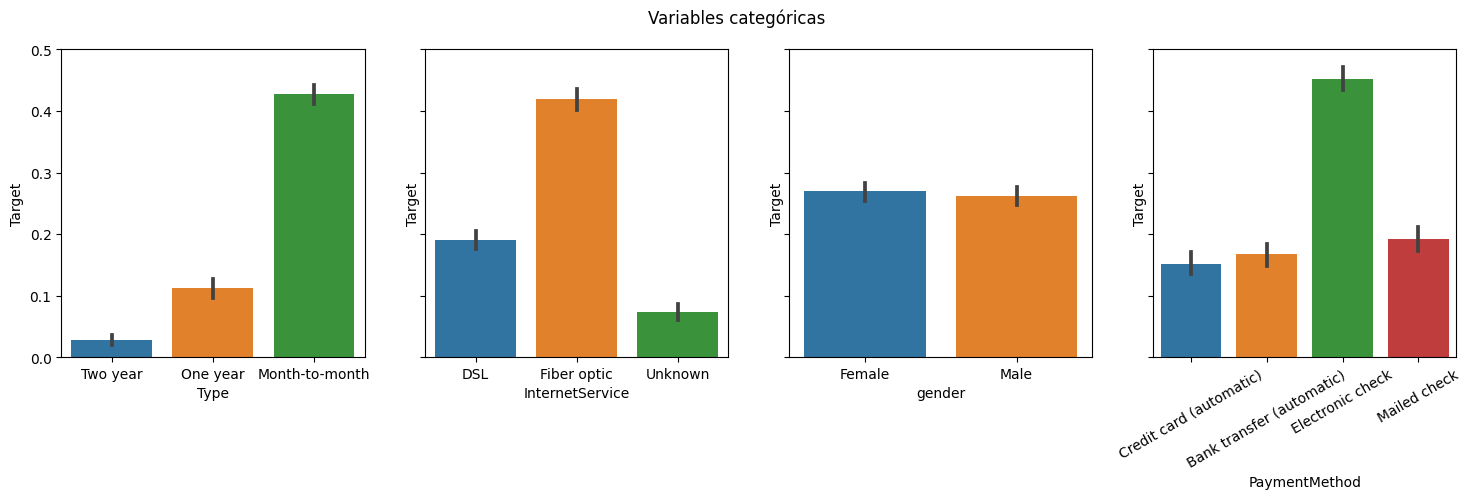

In [39]:
# Análisis de las variables categóricas
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)
fig.suptitle('Variables categóricas')

sns.barplot(ax=axes[0], data=merged_df, x='Type', y='Target')
sns.barplot(ax=axes[1], data=merged_df, x='InternetService', y='Target')
sns.barplot(ax=axes[2], data=merged_df, x='gender', y='Target')
sns.barplot(ax=axes[3], data=merged_df, x='PaymentMethod', y='Target')
plt.xticks(rotation=30)
plt.ylim(0,0.5)
plt.show()

Se observa la distribución de los clientes a través de las diferentes variables categóricas

## Preparación del Dataframe antes del entrenamiento

In [40]:
#Eliminación de columnas no relevantes para el modelo

merged_df.drop(['BeginDate', 'EndDate', 'customerID', 'gender'], axis =1, inplace = True)

#Revisamos el dataframe sin las columnas eliminadas
merged_df.head()

/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,Target
4513,Two year,0,Credit card (automatic),92.45,6440.25,DSL,1,1,1,1,1,1,1,1,1,1,1
4610,One year,1,Bank transfer (automatic),117.80,8684.80,Fiber optic,1,1,1,1,1,1,0,1,0,1,1
3439,Two year,1,Bank transfer (automatic),104.15,7689.95,Fiber optic,0,1,1,0,1,1,1,1,0,1,1
975,Two year,1,Electronic check,108.05,7532.15,Fiber optic,1,0,1,1,1,1,0,0,0,1,1
3040,Two year,1,Credit card (automatic),108.60,7690.90,Fiber optic,0,1,1,1,1,1,0,1,0,1,1


**Creación de los dataframes con las características y el objetivo**

In [41]:
#separar características de objetivo
features = merged_df.drop(['Target'],axis=1)
target = merged_df['Target']

### Método de codificación One Hot Encoding

In [ ]:
#Aplicamos OHE
features_ohe = pd.get_dummies(features,drop_first=True)

In [43]:
#separar conjunto de entrenamiento y prueba
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe, target, test_size=0.2, shuffle=False)
     

### Estandarización de características numéricas con StandardScaler

In [44]:
#Estandarizamos las columnas numéricas
numeric = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] =scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] =scaler.transform(features_test_ohe[numeric])
print(features_train_ohe[numeric].describe())

       MonthlyCharges  TotalCharges
count    5.625000e+03  5.625000e+03
mean    -2.021099e-16 -4.042199e-17
std      1.000089e+00  1.000089e+00
min     -1.629614e+00 -1.236222e+00
25%     -8.001801e-01 -8.415484e-01
50%      2.300301e-01 -3.462897e-01
75%      8.537516e-01  7.420103e-01
max      1.678249e+00  2.629455e+00


/tmp/ipykernel_82/1845932540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric] =scaler.transform(features_train_ohe[numeric])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_82/1845932540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

### Balancear características

In [45]:
# Función para duplicar datos de las cancelaciones:
def upsample(features, target):
  repeat = 2

  #Separar respuestas de conjunto de datos de entrenamiento
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  #Aumentar observaciones positivas (donde cancelaron)
  features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
  target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

  #reordenar datos por fecha
  features_upsampled.sort_index(inplace=True)
  target_upsampled.sort_index(inplace=True)

  return features_upsampled, target_upsampled

In [46]:
#Duplicamos los datos de las cancelaciones
features_train_ohe, target_train_ohe = upsample(features_train_ohe, target_train_ohe)

## Entrenamiento del modelo

### Función para evaluar modelos

In [47]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Modelo de Regresión Logística

In [48]:
#Establecemos el modelo y lo entrenamos
model_lr = LogisticRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

LogisticRegression()

           train  test
Exactitud    NaN   NaN
F1          0.67  0.66
APS         0.74  0.71
ROC AUC     0.85  0.75


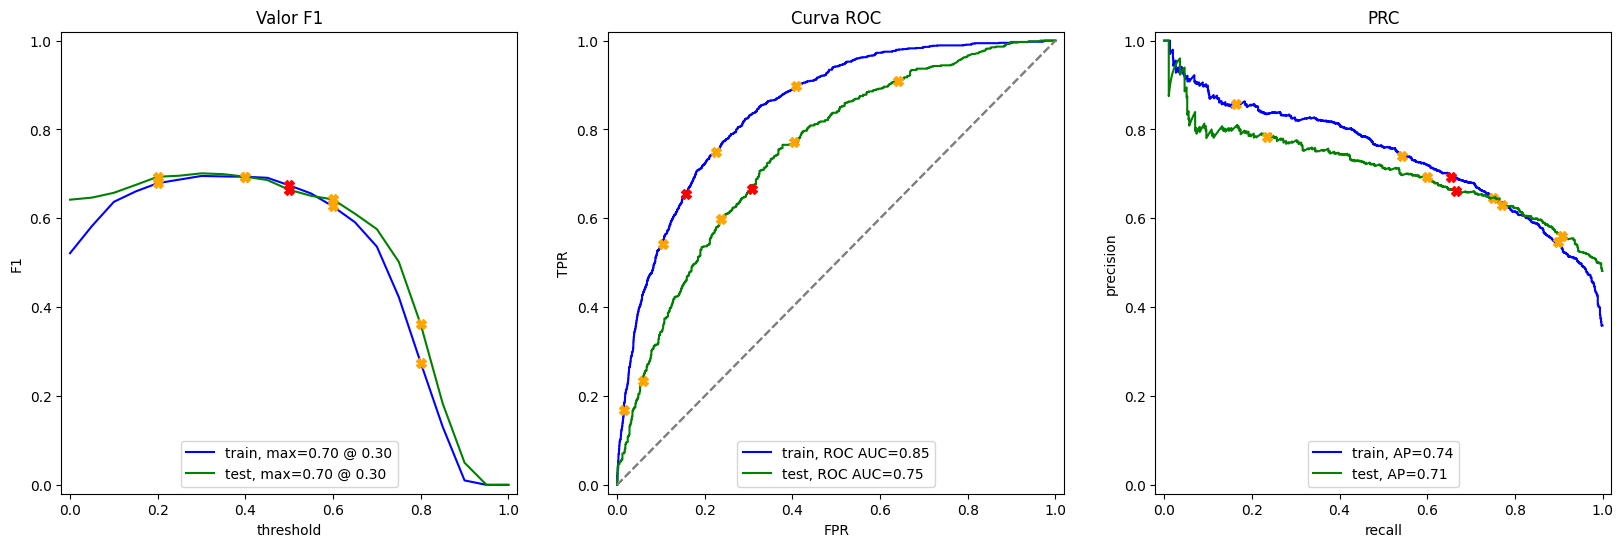

In [49]:
#Evaluación del modelo de regresión logística
evaluate_model(model_lr, features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe)

### Modelo de Bosque Aleatorio para clasificación

In [50]:
#Buscamos las mejores características para los datos disponibles

param_grid_1 = {'n_estimators': [1,2,3,4,6,8,10,20],'max_features': [ 'sqrt', 'log2'],'max_depth' : [2,3,4,5,6,8,10,20]}

model_rfc = RandomForestClassifier(random_state=12345)

grid_search_rfc = GridSearchCV(estimator=model_rfc, param_grid=param_grid_1, scoring='roc_auc')

grid_search_rfc.fit(features_train_ohe, target_train_ohe)
grid_search_rfc.best_params_  

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 20}

In [51]:
#Establecemos el modelo y lo entrenamos
model_rfc = RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=20, random_state=12345)
model_rfc.fit(features_train_ohe, target_train_ohe)

RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=20,
                       random_state=12345)

           train  test
Exactitud    NaN   NaN
F1          0.74  0.67
APS         0.83  0.67
ROC AUC     0.91  0.70


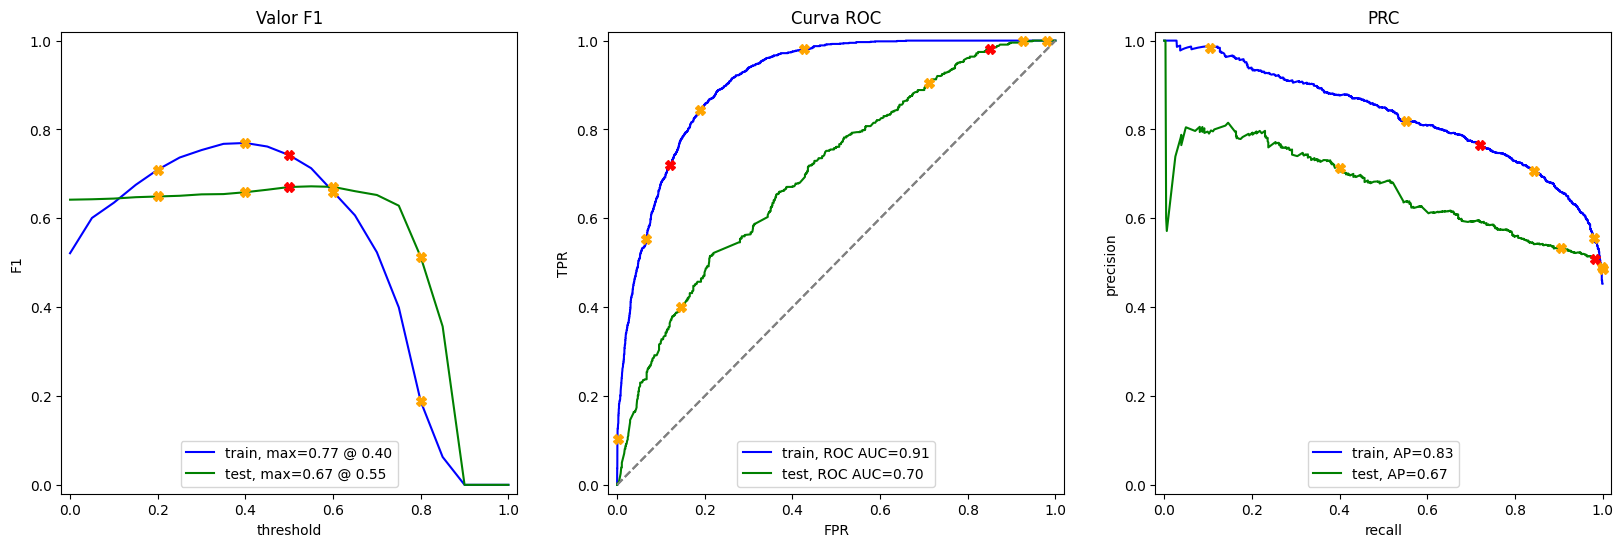

In [52]:
#Evaluación del modelo de bosque aleatorio para clasificación
evaluate_model(model_rfc, features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe)

## Modelo CatBoostClassifier

In [53]:
#Encontramos los mejores parámetros para el modelo
model_cbc = CatBoostClassifier(random_seed=123456, verbose=False)
param_grid_3 = {
    'depth':[4, 6, 8, 10],
    'learning_rate':[0.5, 0.1, 0.01],
    'iterations':[10, 30, 50, 100] 
}

grid_search_cbc = GridSearchCV(estimator=model_cbc, 
                           param_grid=param_grid_3, 
                           scoring='roc_auc', 
                           )
grid_search_cbc.fit(features_train_ohe,target_train_ohe)
grid_search_cbc.best_params_ 

{'depth': 6, 'iterations': 50, 'learning_rate': 0.1}

In [54]:
#Entrenamiento del modelo con los mejores parámetros
model_cbc = CatBoostClassifier(depth=6, iterations=50, learning_rate=0.1, random_seed=123456, verbose=False)
model_cbc.fit(features_train_ohe, target_train_ohe)

           train  test
Exactitud    NaN   NaN
F1          0.71  0.67
APS         0.81  0.74
ROC AUC     0.89  0.78


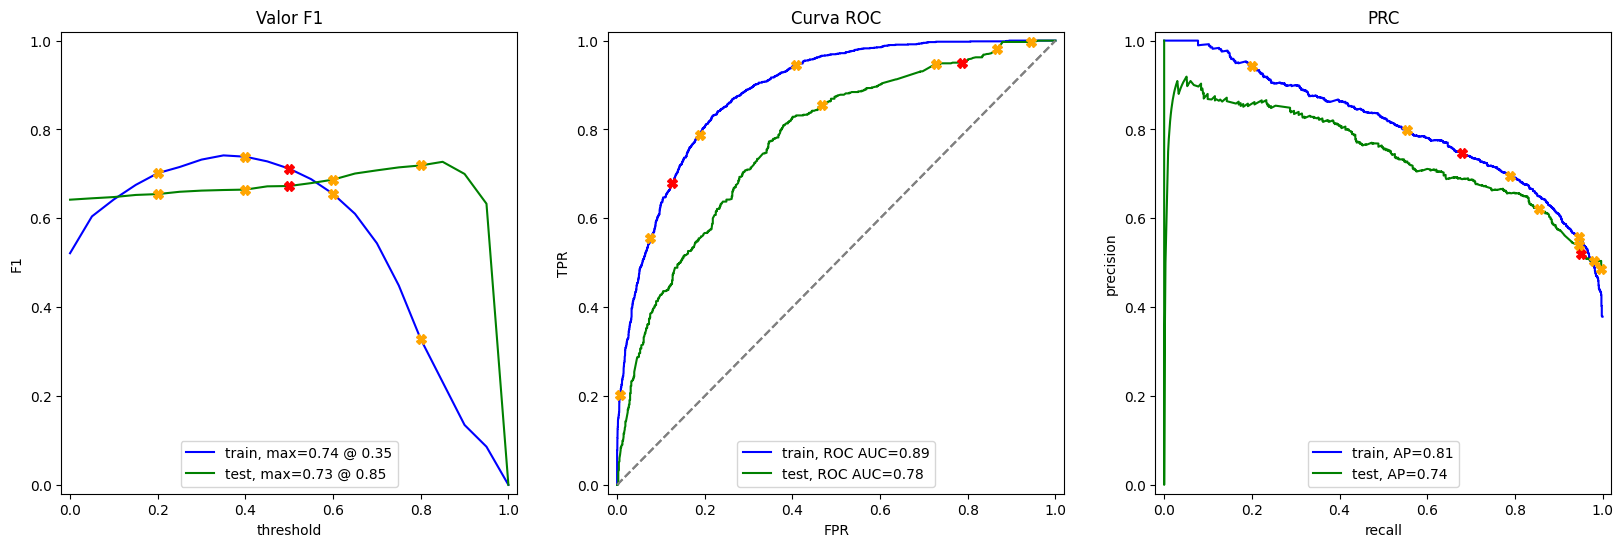

In [55]:
#Evaluación del modelo CatBoostClassifier
evaluate_model(model_cbc, features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe)

## Conclusiones

Después de evaluar los diferentes modelos podemos llegar a las siguientes conclusiones:

1. El modelo de bosque aleatorio para la clasificación tiene una gran capacidad para identificar la diferencia entre las clases positivas y negativas, en el 91% de los casos para el conjunto de entrenamiento, el modelos clasificaría correctamente una instancia positiva como más probable que una instancia negativa, lo cuál es excelente, sin embargo para el conjunto de prueba esto sólo pasaría en el 70% de los casos.

2. Por otro lado el modelo CatboostClassifier tiene unos valores más balanceados en cuanto a las métricas analizadas en general, con un 89% para el conjunto de entrenamiento y 78% para el conjunto de prueba. Considería que este sería el mejor modelo a usar ya que podría mejorar aún más con el uso de más datos históricos.